In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# text summarization

In [3]:
df = pd.read_json(open("data/text_summarization_result.txt", "r", encoding="utf8"), lines=True)

In [4]:
df.head()

,rouge1,rouge2,rougeL,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1
0,0.453333,0.191781,0.346667,000571afe702684d90c1d222ce70b1e1375c1016,WatermarkLogitsProcessor_John(vocab_size=50264...,0.434302,0.449585,0.442741
1,0.414414,0.128440,0.270270,000642916e3a6c33411c617cf2f3c134a206fba8,WatermarkLogitsProcessor_John(vocab_size=50264...,0.385303,0.257307,0.320173
2,0.387097,0.081967,0.177419,00110802bc6eae0e8e4d3d22e27f458f41be2b22,WatermarkLogitsProcessor_John(vocab_size=50264...,0.330308,0.334348,0.333314
3,0.285714,0.097561,0.238095,00119229166ae09a6ef25c0e10b101ef9eb9cca3,WatermarkLogitsProcessor_John(vocab_size=50264...,0.276365,0.390081,0.332545
4,0.211538,0.039216,0.134615,0013aa16650fbcfbe6edb16ac614ad174cb5d1cf,WatermarkLogitsProcessor_John(vocab_size=50264...,0.213453,0.235213,0.225417


In [5]:
# nested dict to dataframe
show_wp = ["No Watermark", "$\delta$-reweight", "$\gamma$-reweight"]
john_wps = set()


def map_wp_str(wp_str):
    if "Delta" in wp_str:
        return show_wp[1]
    elif "Gamma" in wp_str:
        return show_wp[2]
    elif "John" in wp_str:
        import re

        delta = re.findall(r"delta=(\d+\.?\d*)", wp_str)[0]
        n = "Soft Red List" + f"($\delta$={delta})"
        john_wps.add(n)
        return n
    if wp_str == "None":
        return show_wp[0]
    else:
        raise ValueError("Unknown watermark: {}".format(wp_str))

df = df.assign(wp_str=df["watermark_processor"].apply(map_wp_str))
john_wps = sorted(list(john_wps))
df.head()

,rouge1,rouge2,rougeL,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1,wp_str
0,0.453333,0.191781,0.346667,000571afe702684d90c1d222ce70b1e1375c1016,WatermarkLogitsProcessor_John(vocab_size=50264...,0.434302,0.449585,0.442741,Soft Red List($\delta$=0.0)
1,0.414414,0.128440,0.270270,000642916e3a6c33411c617cf2f3c134a206fba8,WatermarkLogitsProcessor_John(vocab_size=50264...,0.385303,0.257307,0.320173,Soft Red List($\delta$=0.0)
2,0.387097,0.081967,0.177419,00110802bc6eae0e8e4d3d22e27f458f41be2b22,WatermarkLogitsProcessor_John(vocab_size=50264...,0.330308,0.334348,0.333314,Soft Red List($\delta$=0.0)
3,0.285714,0.097561,0.238095,00119229166ae09a6ef25c0e10b101ef9eb9cca3,WatermarkLogitsProcessor_John(vocab_size=50264...,0.276365,0.390081,0.332545,Soft Red List($\delta$=0.0)
4,0.211538,0.039216,0.134615,0013aa16650fbcfbe6edb16ac614ad174cb5d1cf,WatermarkLogitsProcessor_John(vocab_size=50264...,0.213453,0.235213,0.225417,Soft Red List($\delta$=0.0)


Text(0.5, 0, 'Watermark')

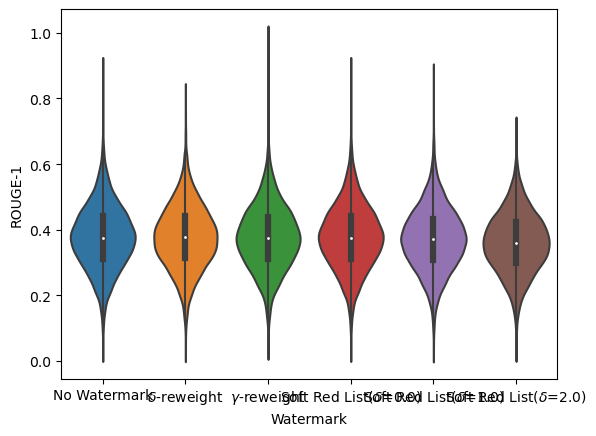

In [6]:
import seaborn as sns

sns.violinplot(
    data=df, x="wp_str", y="rouge1", order=show_wp + john_wps
)
plt.ylabel("ROUGE-1")
plt.xlabel("Watermark")

In [7]:
sdf=df.melt(
    id_vars=["wp_str"],
    value_vars=[c for c in df.columns if df[c].dtype == np.float64],
    var_name="score",
    value_name="value",
)
sdf = sdf.groupby(["wp_str", "score"]).agg(["mean", "std", "count"])
sdf = (
    sdf["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"] / np.sqrt(x["count"])),
        axis=1,
    )
    .unstack()
)
sdf = sdf.loc[show_wp + john_wps]
sdf

score,bertscore.f1,bertscore.precision,bertscore.recall,rouge1,rouge2,rougeL
wp_str,,,,,,
No Watermark,0.3175±0.0008,0.3058±0.0009,0.3295±0.0010,0.3774±0.0009,0.1323±0.0007,0.2380±0.0007
$\delta$-reweight,0.3176±0.0008,0.3060±0.0009,0.3293±0.0009,0.3779±0.0009,0.1329±0.0007,0.2385±0.0007
$\gamma$-reweight,0.3170±0.0008,0.3058±0.0009,0.3284±0.0010,0.3764±0.0009,0.1322±0.0007,0.2379±0.0007
Soft Red List($\delta$=0.0),0.3175±0.0008,0.3058±0.0009,0.3295±0.0010,0.3774±0.0009,0.1323±0.0007,0.2380±0.0007
Soft Red List($\delta$=1.0),0.3120±0.0008,0.2949±0.0009,0.3294±0.0009,0.3719±0.0009,0.1274±0.0007,0.2326±0.0007
Soft Red List($\delta$=2.0),0.2996±0.0008,0.2751±0.0008,0.3246±0.0009,0.3610±0.0009,0.1166±0.0007,0.2215±0.0007


# translation

In [8]:
df = pd.read_json(open("data/machine_translation_result.txt", "r", encoding="utf8"), lines=True)

In [9]:
df.head()

,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1
0,29d0c7b54f4eae90782cef19430fe1544a5584e9,None,0.720704,0.597597,0.657975
1,29d43003700d07e739bc821db18dbea16c7a2600,None,0.404521,0.429197,0.417648
2,29f46c89728ed740d91c24d2544ba522e2b72a74,None,0.171877,0.074673,0.123197
3,2a1153b9393207e7ef490161d5018c22fe7e0382,None,0.747968,0.797916,0.773017
4,2a46f1bb58ba2ead5588b98ba3d35efaf1e05ef0,None,0.015038,0.090594,0.053359


In [10]:
john_wps = set()
df = df.assign(wp_str=df["watermark_processor"].apply(map_wp_str))
john_wps = sorted(list(john_wps))
df.head()

,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1,wp_str
0,29d0c7b54f4eae90782cef19430fe1544a5584e9,None,0.720704,0.597597,0.657975,No Watermark
1,29d43003700d07e739bc821db18dbea16c7a2600,None,0.404521,0.429197,0.417648,No Watermark
2,29f46c89728ed740d91c24d2544ba522e2b72a74,None,0.171877,0.074673,0.123197,No Watermark
3,2a1153b9393207e7ef490161d5018c22fe7e0382,None,0.747968,0.797916,0.773017,No Watermark
4,2a46f1bb58ba2ead5588b98ba3d35efaf1e05ef0,None,0.015038,0.090594,0.053359,No Watermark


Text(0.5, 0, 'Watermark')

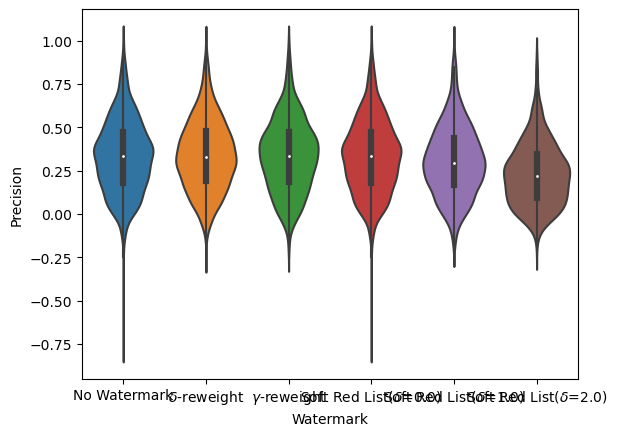

In [11]:
import seaborn as sns

sns.violinplot(
    data=df, x="wp_str", y="bertscore.precision", order=show_wp + john_wps
)
plt.ylabel("Precision")
plt.xlabel("Watermark")

In [12]:
sdf=df.melt(
    id_vars=["wp_str"],
    value_vars=[c for c in df.columns if df[c].dtype == np.float64],
    var_name="score",
    value_name="value",
)
sdf = sdf.groupby(["wp_str", "score"]).agg(["mean", "std", "count"])
sdf = (
    sdf["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"] / np.sqrt(x["count"])),
        axis=1,
    )
    .unstack()
)
sdf = sdf.loc[show_wp + john_wps]
sdf

score,bertscore.f1,bertscore.precision,bertscore.recall
wp_str,,,
No Watermark,0.3490±0.0037,0.3330±0.0038,0.3655±0.0038
$\delta$-reweight,0.3570±0.0036,0.3408±0.0037,0.3738±0.0037
$\gamma$-reweight,0.3520±0.0037,0.3366±0.0038,0.3680±0.0038
Soft Red List($\delta$=0.0),0.3490±0.0037,0.3330±0.0038,0.3655±0.0038
Soft Red List($\delta$=1.0),0.3262±0.0036,0.3053±0.0037,0.3477±0.0037
Soft Red List($\delta$=2.0),0.2583±0.0033,0.2299±0.0033,0.2877±0.0034
